# Question word prediction by classification

> Group 12: Tristan Perrot & Romain Darous

Task is to train and evaluate a QWP model using any available QA-corpus, for instance, the [SQuAD corpus](https://rajpurkar.github.io/SQuAD-explorer/).


In [1]:
import json
import math
import os

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
from transformers import (BertForSequenceClassification, BertTokenizer,
                          Trainer, TrainingArguments)

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-05-22 17:21:31.721332: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 17:21:31.821498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 17:21:31.821541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 17:21:31.822705: E external/local_xla/xla/stream_executor/cuda/c

In [2]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")
device

NVIDIA H100 80GB HBM3 MIG 1g.10gb


device(type='cuda')

## Data


In [3]:
data_dir = 'data'

In [4]:
if data_dir not in os.listdir():
    os.mkdir(data_dir)

if "squad_train.json" not in os.listdir(data_dir):
    # Download data at https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
    res = requests.get(
        "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json")
    data = json.loads(res.text)

    # Save data to file
    with open(data_dir + "/squad_train.json", "w") as f:
        json.dump(data, f)

with open(data_dir + "/squad_train.json", "r") as f:
    data = json.load(f)

# Extract answer text and question text
answers = []
questions = []
for article in data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                continue
            answers.append(qa["answers"][0]["text"])
            questions.append(qa["question"])

print("Number of questions:", len(questions))

# Print some examples
for i in range(5):
    print()
    print("Question:", questions[i])
    print("Answer:", answers[i])

Number of questions: 86821

Question: When did Beyonce start becoming popular?
Answer: in the late 1990s

Question: What areas did Beyonce compete in when she was growing up?
Answer: singing and dancing

Question: When did Beyonce leave Destiny's Child and become a solo singer?
Answer: 2003

Question: In what city and state did Beyonce  grow up? 
Answer: Houston, Texas

Question: In which decade did Beyonce become famous?
Answer: late 1990s


In [5]:
words_to_pred = [
    'What',
    'When',
    'Where',
    'Who',
    'Whom',
    'Whose',
    'Which',
    'How',
    'Whether',
    'Why',
    'In what',
    'In which',
    'How much',
    'How many',
]

In [6]:
restricted_questions = []
restricted_answers = []
question_words = []

for i in range(len(questions)):
    for word in words_to_pred:
        if questions[i].startswith(word):
            question = questions[i]
            masked_question = question.replace(word, "[MASK]")
            restricted_questions.append(masked_question)
            restricted_answers.append(answers[i])
            question_words.append(word)
            break

print("Number of restricted questions:", len(restricted_questions))

# Print some examples
for i in range(5):
    print()
    print("Question:", restricted_questions[i])
    print("Answer:", restricted_answers[i])
    print("Question word:", question_words[i])

Number of restricted questions: 70292

Question: [MASK] did Beyonce start becoming popular?
Answer: in the late 1990s
Question word: When

Question: [MASK] areas did Beyonce compete in when she was growing up?
Answer: singing and dancing
Question word: What

Question: [MASK] did Beyonce leave Destiny's Child and become a solo singer?
Answer: 2003
Question word: When

Question: [MASK] city and state did Beyonce  grow up? 
Answer: Houston, Texas
Question word: In what

Question: [MASK] decade did Beyonce become famous?
Answer: late 1990s
Question word: In which


In [7]:
df = pd.DataFrame({
    "question": restricted_questions,
    "answer": restricted_answers,
    "question_word": question_words
})

df.head()

,question,answer,question_word
0,[MASK] did Beyonce start becoming popular?,in the late 1990s,When
1,[MASK] areas did Beyonce compete in when she w...,singing and dancing,What
2,[MASK] did Beyonce leave Destiny's Child and b...,2003,When
3,[MASK] city and state did Beyonce grow up?,"Houston, Texas",In what
4,[MASK] decade did Beyonce become famous?,late 1990s,In which


In [8]:
question_word_to_id = {word: idx for idx, word in enumerate(words_to_pred)}
df['label'] = df['question_word'].map(question_word_to_id)

In [9]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.head()

,question,answer,question_word,label
0,[MASK] did Ireland issue a new constitution?,1937,When,1
1,[MASK] are larger weapon systems usually mount...,trailers,What,0
2,[MASK] did American Idols first winner sing at...,the national anthem,What,0
3,[MASK] currently owns the Chicago Cubs?,Joe Ricketts,Who,3
4,[MASK] many works of a cappella in musical the...,four,How,7


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class QuestionAnswerDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = str(self.data.loc[index, 'question'])
        answer = str(self.data.loc[index, 'answer'])
        inputs = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.data.loc[index, 'label'], dtype=torch.long)
        }

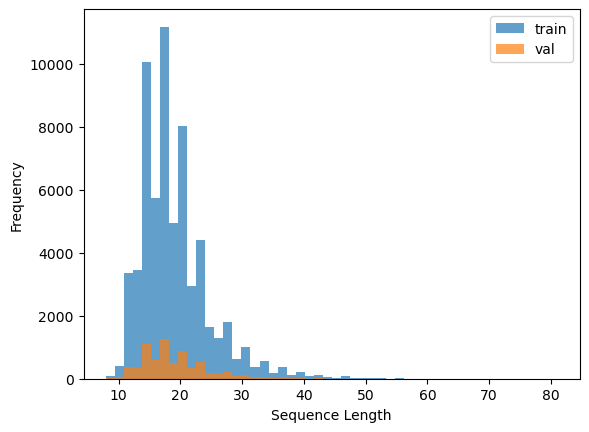

Max length in train dataset: 81
Max length in val dataset: 81
95th percentile length in train dataset: 30.0
95th percentile length in val dataset: 30.0


In [11]:
def get_sequence_lengths(dataframe, tokenizer):
    lengths = []
    for idx, row in dataframe.iterrows():
        question = str(row['question'])
        answer = str(row['answer'])
        inputs = tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True
        )
        lengths.append(len(inputs['input_ids']))
    return lengths


# Analyze lengths for the training dataset
train_lengths = get_sequence_lengths(train_df, tokenizer)
val_lengths = get_sequence_lengths(val_df, tokenizer)

plt.hist(train_lengths, bins=50, alpha=0.7, label='train')
plt.hist(val_lengths, bins=50, alpha=0.7, label='val')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Print some statistics
print(f'Max length in train dataset: {max(train_lengths)}')
print(f'Max length in val dataset: {max(val_lengths)}')
print(f'95th percentile length in train dataset: {np.percentile(train_lengths, 95)}')
print(f'95th percentile length in val dataset: {np.percentile(val_lengths, 95)}')

In [12]:
train_dataset = QuestionAnswerDataset(train_df, tokenizer, max_len=128)
val_dataset = QuestionAnswerDataset(val_df, tokenizer, max_len=128)

In [13]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(words_to_pred)).to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [14]:
trainer.train()
trainer.evaluate()

Step,Training Loss
1000,0.874000
2000,0.438500
3000,0.416700
4000,0.386300
5000,0.386700
6000,0.384300
7000,0.359700
8000,0.357000
9000,0.270300
10000,0.283300


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4395584166049957,
 'eval_runtime': 42.8764,
 'eval_samples_per_second': 163.96,
 'eval_steps_per_second': 20.501,
 'epoch': 3.0}

In [15]:
# Save model
model.save_pretrained('models')

In [16]:
# Load model
model = BertForSequenceClassification.from_pretrained('models').to(device)

In [17]:
def predict_question_word(question, answer, model, tokenizer, question_words):
    inputs = tokenizer.encode_plus(
        question,
        answer,
        add_special_tokens=True,
        return_tensors='pt'
    )
    outputs = model(**inputs.to(device))
    logits = outputs.logits
    predicted_idx = logits.argmax().item()
    return question_words[predicted_idx]


In [19]:
question = " is the capital of France?"
question = "[MASK]" + question
answer = "Paris"
predicted_question_word = predict_question_word(question, answer, model, tokenizer, words_to_pred)
predicted_question_word

'What'

In [24]:
question = " did Beyonce start becoming popular??"
question = "[MASK] " + question
answer = "in the late 1990s"
predicted_question_word = predict_question_word(
    question, answer, model, tokenizer, words_to_pred)
predicted_question_word

'When'